In [1]:
import pandas as pd 
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express  as px
import os
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [3]:
import matplotlib as mlp
sns.set_style('darkgrid')
mlp.rcParams['font.size']=10
mlp.rcParams['figure.figsize']=(10,10)

In [4]:
raw_df=pd.read_csv('.\weather-dataset-rattle-package\weatherAUS.csv')

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [6]:
raw_df.RainTomorrow.isna().sum()

3267

In [7]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

<AxesSubplot:title={'center':'records per year'}, xlabel='Date', ylabel='count'>

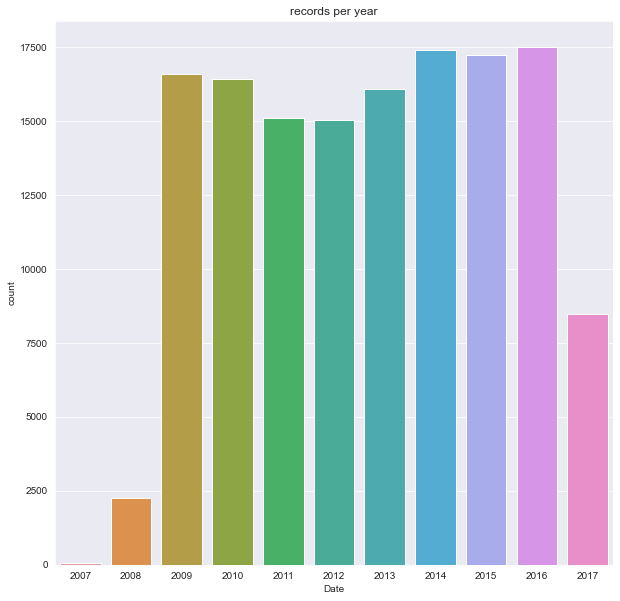

In [8]:
plt.title('records per year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year)

In [9]:
year=pd.to_datetime(raw_df.Date).dt.year

train=raw_df[year<2015]
val=raw_df[year==2015]
test=raw_df[year>2015]

In [10]:
train.shape, test.shape, val.shape

((98988, 23), (25974, 23), (17231, 23))

In [11]:
target='RainTomorrow'

In [12]:
train_input=train.iloc[0:,1:-1].copy()
train_target=train[target].copy()

val_input=val.iloc[0:,1:-1].copy()
val_target=val[target].copy()


test_input=test.iloc[0:,1:-1].copy()
test_target=test[target].copy()

In [13]:
train_input.shape,val_input.shape,test_input.shape

((98988, 21), (17231, 21), (25974, 21))

In [14]:
numeric_cols=raw_df.select_dtypes(include=np.number).columns.tolist()
cat_cols=train.select_dtypes('object').columns.tolist()

#### Lets do some data preprocessing--->> 
1. imputing to fill Nan
2. scaling to avoid termoil in optimization
3. one hot encoding for categorical columns

In [15]:
from sklearn.impute import SimpleImputer

In [16]:
imputer=SimpleImputer(strategy='mean')
imputer.fit(raw_df[numeric_cols])

SimpleImputer()

In [17]:
train_input[numeric_cols]=imputer.transform(train_input[numeric_cols])
val_input[numeric_cols]=imputer.transform(val_input[numeric_cols])
test_input[numeric_cols]=imputer.transform(test_input[numeric_cols])

In [18]:
imputer.statistics_

array([  12.18639973,   23.22678419,    2.34997407,    5.46982422,
          7.62485311,   39.98429166,   14.001988  ,   18.63757586,
         68.84381031,   51.48260609, 1017.65375842, 1015.25820354,
          4.43718939,    4.5031669 ,   16.98750858,   21.68723497])

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
## we sacle numeric columns where as categorical columns are encoded in the range of 0 to 1

scale=MinMaxScaler().fit(raw_df[numeric_cols])

In [21]:
train_input[numeric_cols]=scale.transform(train_input[numeric_cols])
val_input[numeric_cols]=scale.transform(val_input[numeric_cols])
test_input[numeric_cols]=scale.transform(test_input[numeric_cols])

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
category=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [24]:
encoder=OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[category].fillna('unknown'))

In [25]:

encode_cols=list(encoder.get_feature_names(category))



In [26]:
train_input[encode_cols]=encoder.transform(train_input[category].fillna('unknown'))
val_input[encode_cols]=encoder.transform(val_input[category].fillna('unknown'))
test_input[encode_cols]=encoder.transform(test_input[category].fillna('unknown'))

In [27]:
x_train=train_input[numeric_cols+encode_cols]

In [28]:
x_val=val_input[numeric_cols+encode_cols]
x_test=test_input[numeric_cols+encode_cols]

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
#model=RandomForestClassifier(n_estimators=120,max_depth=54,random_state=42)
model=RandomForestClassifier(n_jobs=-1,random_state=42)




In [64]:
%%time
model.fit(x_train,train_target)

Wall time: 8.55 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [65]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [66]:
prediction= model.predict(x_train)
accuracy_score(prediction,train_target)

0.9999494888269285

In [67]:
model.score(x_val,val_target)

0.8566537055307295

In [68]:
cf=confusion_matrix(train_target,prediction)
cf

array([[76705,     0],
       [    5, 22278]], dtype=int64)

<AxesSubplot:>

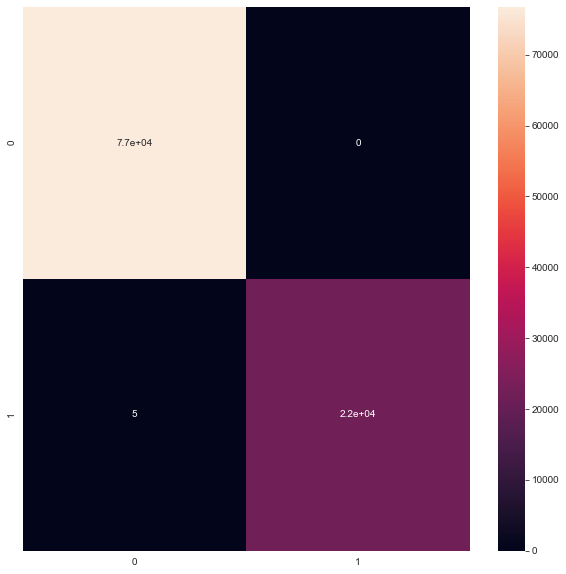

In [69]:

sns.heatmap(data=cf,annot=True)

#### ensembling
**An approach of combining the results of more models is ensembling. Random forest is better than single decision tree because random forest is combination of decision trees. And combining more models cancel out the error.**  
    

In [71]:
## well in random forest, for instance if we consider first predicted value in each models, probalility of occurence of NO 
## as a result in the number of  models  is calculated 
train_prob=model.predict_proba(x_train)
train_prob

array([[0.93, 0.07],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04]])

In [74]:
len(model.estimators_)

100

In [75]:
from sklearn.tree import plot_tree, export_text

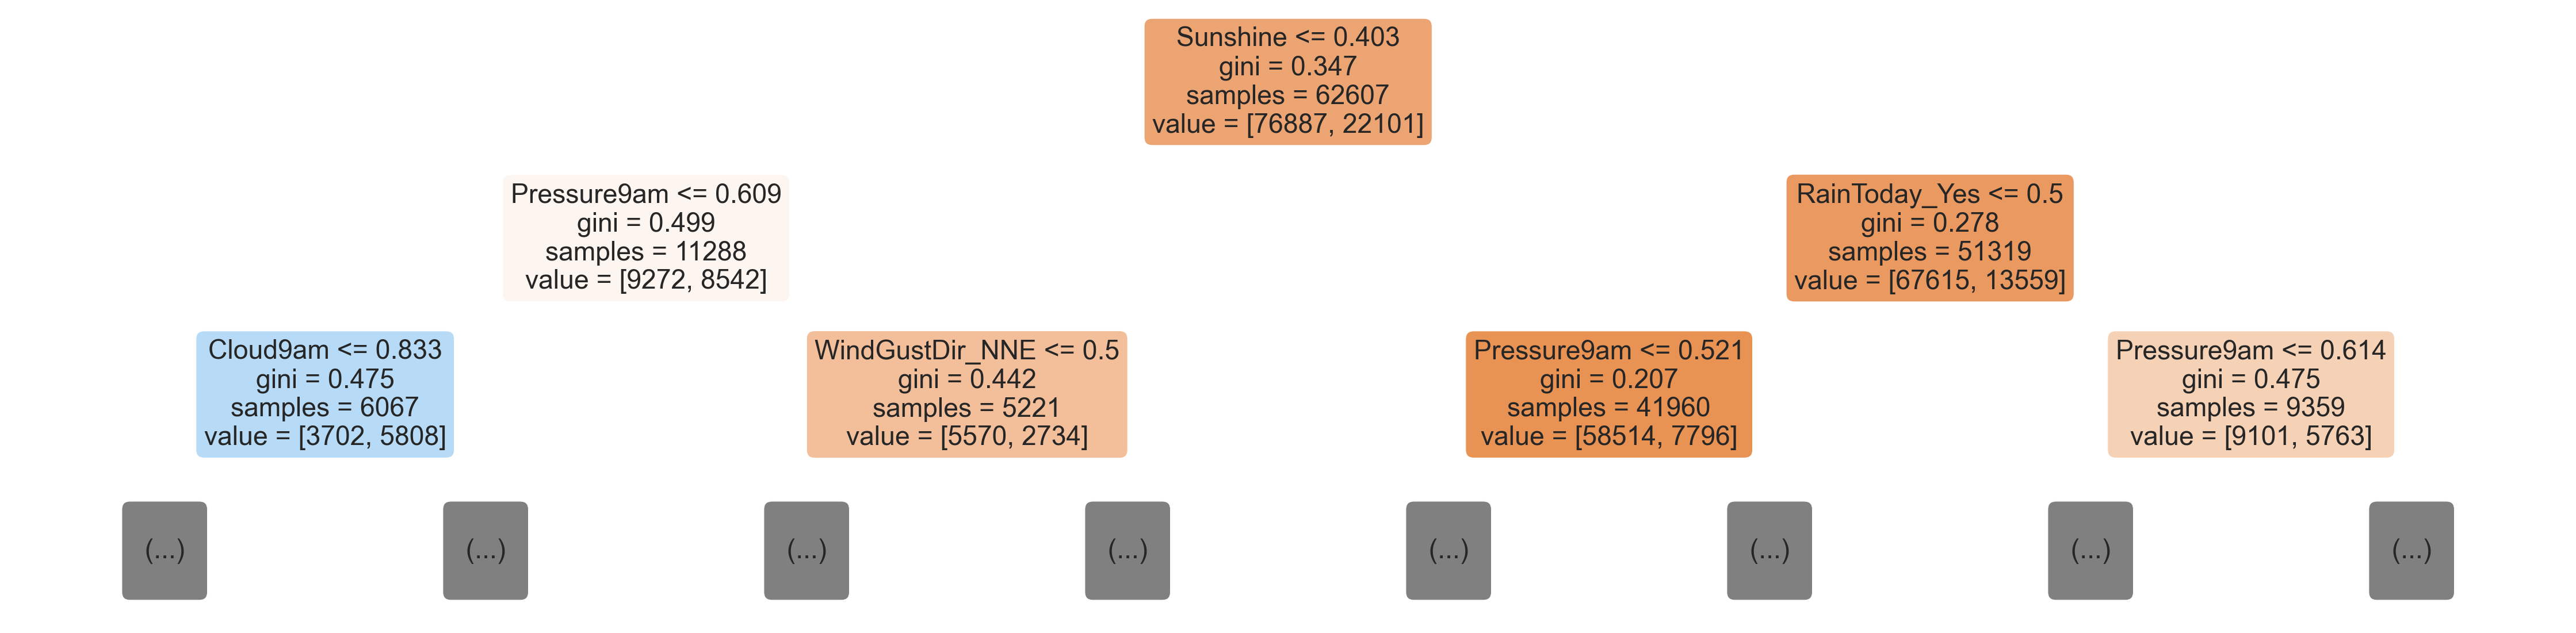

In [81]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], feature_names=list(x_train.columns), max_depth=2,filled=True, rounded=True);

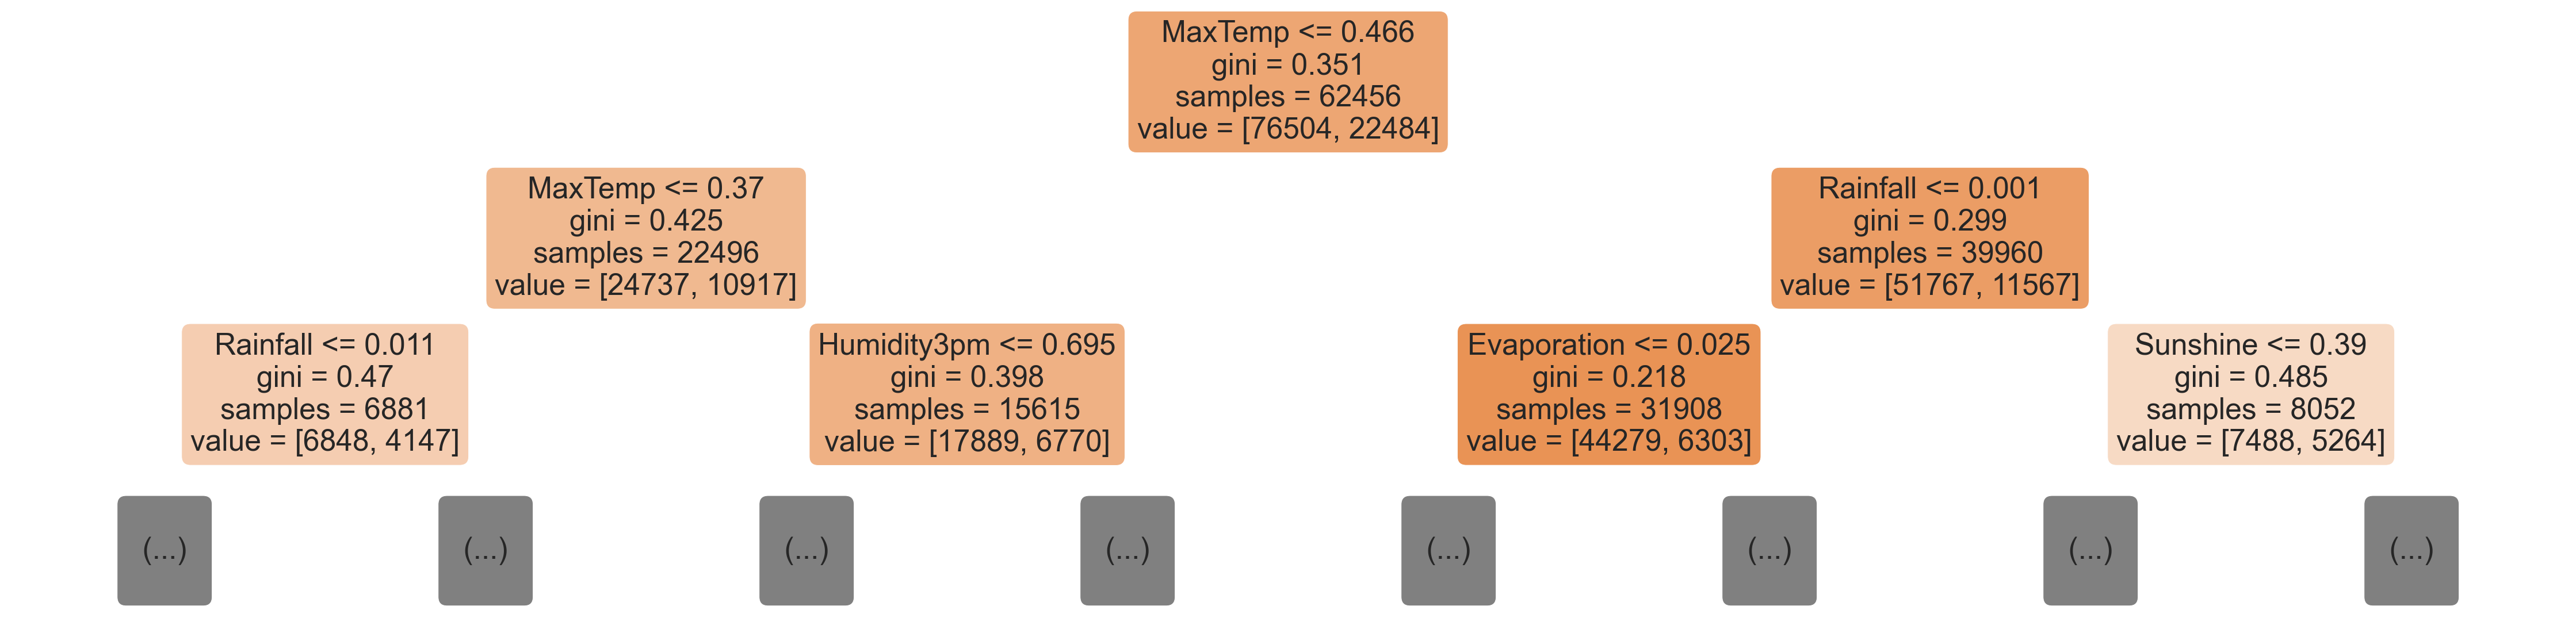

In [87]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[21], feature_names=x_train.columns, max_depth=2,filled=True, rounded=True);

##### Lets look into the feature importance of the given model

In [90]:
imp_df=pd.DataFrame({'features':x_train.columns,
                    'importance':model.feature_importances_
                    
                    })

In [92]:
imp_df.head(20)

,features,importance
0,MinTemp,0.041199
1,MaxTemp,0.041865
2,Rainfall,0.048077
3,Evaporation,0.024394
4,Sunshine,0.053696
5,WindGustSpeed,0.047477
6,WindSpeed9am,0.028047
7,WindSpeed3pm,0.030621
8,Humidity9am,0.050051
9,Humidity3pm,0.139904


<AxesSubplot:xlabel='importance', ylabel='features'>

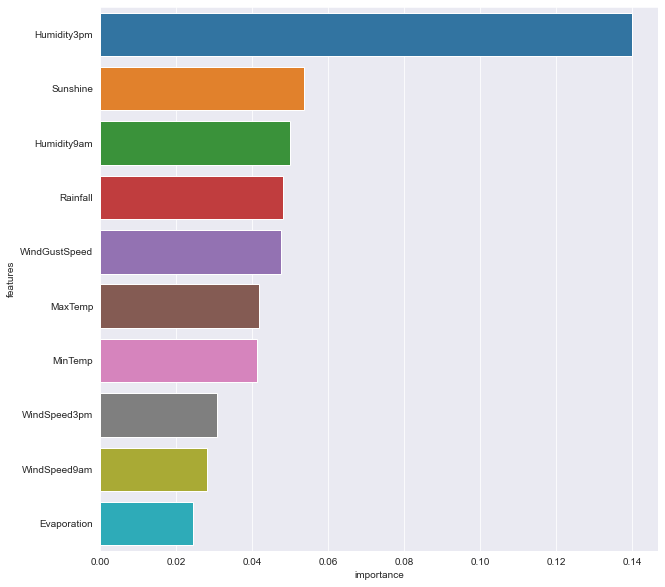

In [94]:
sns.barplot(data=imp_df.head(10).sort_values('importance', ascending=False), x='importance',y='features')

#### Hyperparameter tuning 
1. n_estimators-->> number of trees
2. max_depth--->>> complexity/ upto which it will divide
3. max_leaf_node-->> number of leaf nodes in each model

In [102]:
def rand_est(md):
    hy_df={'train_acc':[], 'val_acc':[]}
    model_est=RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=md)
    model_est.fit(x_train, train_target)
    prediction=model_est.predict(x_train)
    train_acc=accuracy_score(train_target, prediction)
    val_acc=model_est.score(x_val,val_target)
    hy_df['train_acc'].append(train_acc)
    hy_df['val_acc'].append(val_acc)
    return hy_df

In [104]:
rand_est(200)

{'train_acc': [0.9999797955307714], 'val_acc': [0.8561894260344728]}

In [105]:
rand_est(250)

{'train_acc': [0.9999797955307714], 'val_acc': [0.8572340549010504]}

In [106]:
rand_est(300)

{'train_acc': [0.9999797955307714], 'val_acc': [0.8573501247751146]}

In [109]:
%%time
rand_est(450)

Wall time: 39.3 s


{'train_acc': [0.9999797955307714], 'val_acc': [0.8576402994602751]}

#### max_depth and max_leaf_node

In [132]:
def max_hy(**params):
    model=RandomForestClassifier(random_state=43,n_jobs=-1,**params).fit(x_train,train_target)
    train_acc=model.score(x_train,train_target)
    val_acc=model.score(x_val,val_target)
    return train_acc, val_acc

In [125]:
max_hy(max_depth=45,max_leaf_nodes=2**20)

(0.9999494888269285, 0.856363530845569)

#### Max_features
**number of features, in general random forest will pick the random rows & columns for the best split, but what if we customize it as well.<br>
<br>
  **max_features : {"auto", "sqrt", "log2"}, int or float, default="auto"
    The number of features to consider when looking for the best split:**

    - If int, then consider `max_features` features at each split.
    - If float, then `max_features` is a fraction and
      `int(max_features * n_features)` features are considered at each
      split.
    - If "auto", then `max_features=sqrt(n_features)`.
    - If "sqrt", then `max_features=sqrt(n_features)` (same as "auto").
    - If "log2", then `max_features=log2(n_features)`.
    - If None, then `max_features=n_features`.

    Note: the search for a split does not stop until at least one
    valid partition of the node samples is found, even if it requires to
    effectively inspect more than ``max_features`` features.


In [128]:
max_hy(max_features='log2')

(0.9999696932961571, 0.8567117404677616)

In [129]:
max_hy(max_features=10)

(0.9999696932961571, 0.8568858452788579)

In [130]:
## if we specify float, it will select that percent of features out of total available features
max_hy(max_features=0.5)

(0.9999595910615429, 0.8560733561604086)

##### min_samples_split and min_samples_leaf
1. min_samples_split-->>> this puts the boundery to the model where in model will split the node, provided number of following leaf nodes after that perticular split should be greater than specified number <br>
2. min_samples_leaf ----->>> node will not split unless leading each nodes after split should have atleast specified number of records 


In [137]:
max_hy(min_samples_split=5, min_samples_leaf=20)

(0.8631955388531943, 0.848877023968429)

min_samples_split and min_samples_leaf is not a good hyperparameter pertaining to our datasets here

lets try **min_impurity_decrease**
IN this case node will split only when the leaf nodes impurity(entropy/gini) value is lesser than the parent node

lets say node about to split have entropy of 0.6, and the leaf nodes ends up having entopy of 0.7 and 0.9 then it won't make any 
contribution in reducing the impurity, then that node will not be splitted

In [138]:
max_hy(min_impurity_decrease=1e-6)

(0.9887562128742878, 0.8550287272938308)

In [139]:
#this could be the best split 
max_hy(min_impurity_decrease=1e-8)

(0.9999595910615429, 0.8583367187046602)

In [140]:
max_hy(min_impurity_decrease=1e-10)

(0.9999494888269285, 0.85694388021589)

In [142]:
max_hy(min_impurity_decrease=1e-2)

(0.774891906089627, 0.7882885497069235)

##### bootstrap and max_samples

**bootstraping is the approach random forest uses to train several models, bootstraps are the randomly selected rows and columns of the datasets and used to trained the model. There might be a possibility of same record  in morethan one bootstraps.**

By default bootstrap is set to **True**, and it can be set to **False**.

**_Max_samples_**-->>
this will set a boundary to pick only the specified percentage of samples out of whole datatsets

In [143]:
max_hy(bootstrap=False)

(0.9999797955307714, 0.857582264523243)

In [144]:
max_hy(max_samples=0.8)

(0.9987675273770558, 0.8567697754047937)

In [145]:
max_hy(max_samples=0.9)

(0.9998585687153998, 0.8578144042713713)

##### class_weight
**Here we have a two classes 'Yes' and 'NO', we can explicitly specify and make the model to give more weightage to the minor class

In [147]:
model.classes_

array(['No', 'Yes'], dtype=object)

In [157]:
train_target.value_counts()/len(train_target)

No     0.774892
Yes    0.225108
Name: RainTomorrow, dtype: float64

In [161]:
max_hy(class_weight='balanced')

(0.9999696932961571, 0.8556090766641519)

In [160]:
max_hy(class_weight={'No':1,'Yes':3})

(0.9999595910615429, 0.8567117404677616)

In [170]:
"""""
LETS PUT EVERYTHING TOGETHER
"""""
model=RandomForestClassifier(random_state=42,
                             n_jobs=-1,## uses multiple thread to run the model
                             n_estimators=450,
                             max_depth=45,
                             max_leaf_nodes=2**20,
                             max_features='auto',
                             min_samples_split=3,
                             min_samples_leaf=3,
                             min_impurity_decrease=1e-8,
                             bootstrap=False,
                             class_weight={'No':1,'Yes':2},## giving more importance to minor class
                             max_samples=0.9 ## uses only 90% of data for every bootstrap 
                            )

model.fit(x_train,train_target)

RandomForestClassifier(bootstrap=False, class_weight={'No': 1, 'Yes': 2},
                       max_depth=45, max_leaf_nodes=1048576, max_samples=0.9,
                       min_impurity_decrease=1e-08, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=450, n_jobs=-1,
                       random_state=42)

In [171]:
model.score(x_train,train_target), model.score(x_val,val_target)

(0.9904028771164182, 0.8574661946491788)

In [172]:
model.score(x_test,test_target)

0.8454993454993455

In [173]:
import joblib

In [182]:
input_=train.iloc[0:,1:-1].copy()
input_cols=list(input_.columns)
input_cols

['Location',
 'MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

In [183]:
model_mod={
    'model':model,
    'imputer': imputer,
    'scale':scale,
    'encoder':encoder,
    'numeric_cols':numeric_cols,
    'encode_cols':encode_cols,
    'category':category,
    'target_cols':'RainTomorrow',
    'input_cols':input_cols
    
}

In [185]:
joblib.dump(model_mod,'rain_pred.joblib')

['rain_pred.joblib']

In [186]:
rain=joblib.load('rain_pred.joblib')

**lets try it for new data**

In [192]:
new_data={'Date':'2021-10-20',
          'Location':'SydneyAirport',
          'MinTemp':23.2,
          'MaxTemp':33.4,
          'Rainfall':10.2,
          'Evaporation':4.8,
          'Sunshine':np.nan,
          'WindGustDir':'NNW',
          'WindGustSpeed':10.0,
          'WindDir9am':'NW',
          'WindDir3pm':'NNE',
          'WindSpeed9am':13.0, 
          'WindSpeed3pm':20.4, 
          'Humidity9am':89.2, 
          'Humidity3pm':58.0,
          'Pressure9am':1000, 
          'Pressure3pm':1001.5,
          'Cloud9am':8.0,  
          'Cloud3pm':5.0, 
          'Temp9am':25.7,
          'Temp3pm':33.0, 
          'RainToday':'Yes', 
          
    
}

In [195]:
new_data=pd.DataFrame([new_data])

In [200]:
new_data[numeric_cols]=imputer.transform(new_data[numeric_cols])
new_data[numeric_cols]=scale.transform(new_data[numeric_cols])
new_data[encode_cols]=encoder.transform(new_data[category])

In [201]:
x_new=new_data[numeric_cols+encode_cols]

In [203]:
x_new

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindGustDir_unknown,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir9am_unknown,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_unknown,RainToday_No,RainToday_Yes,RainToday_unknown
0,0.747642,0.722117,0.027493,0.033103,0.525852,0.031008,0.1,0.234483,0.892,0.58,0.322314,0.3904,0.888889,0.555556,0.694093,0.737044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [205]:
model.predict(x_new)

array(['Yes'], dtype=object)